# Arbitrary Style Image Optization Based Neural Style Transfer


## Overview

This notebook aims to integrate the modifications presented by by Cheng et al. in the paper entitled ['Structure poerserving Neural Style Transfer'](https://www.researchgate.net/publication/335441628_Structure-Preserving_Neural_Style_Transfer)  to preserve structure on two benchmark methodologies for Neural Style Transfer. These two benchmark models are Gatys Model in ['A Neural Algorithm of Artistic Style'](https://arxiv.org/abs/1508.06576), which is basically an IOB (Image optimization based) method. 

The first paper presents a methodology to preserve the semantic integrity of the image uncompromised by the strokes of the brush in the generated pastiche, which can be accomplished by adding edge loss and depth loss in addition to the original content, style and variation losses. This notebook aims to test the modified loss on the original methodology for NST by [Gatys et al](https://arxiv.org/abs/1508.06576).

As Gatys's model presents a benchmark model, and often generates the optimal quality pastiches [1](https://arxiv.org/abs/1705.04058), it implies a slow iterative process in order to generate the pastiche. The methodology is to start with an initialization for the generated image, either with a white noise or a clone of the content, and  calculate the content loss and the style loss using pictures representations using VGG19, then backpropagate over the generated image gradually to generate a pastiche with minimal loss.

The pastiche generation process is optimized based on the overall loss which is a weighted summation of content loss and style loss. Content loss is calculated by Euclidean distance between content and target images, while style loss is calculated by the Euclidean distance between the gram matrix of content and target images. This notebook would aim to fine-tuning Gatys's methodology on a more complex loss function, which will include edge loss and depth loss, which would be calculated as the Euclidian distance between pastiche representation and content representation through a global structure detector module using the model presented in ["Single-image depth perception
in the wild"](https://arxiv.org/abs/1604.03901) by Chen et al.,  and a local structure detector module using the model introduced in ["Holistically-Nested Edge Detection"](https://arxiv.org/abs/1504.06375) by Xie et al.

## Notebook Structure

0- Importing the necessary libraries and frameworks\
1- Defining Hyper-parameters and Helper Functions\
2- Creation of Data Object\
3- Creation of Data Loader\
4- Importing the models used in Loss Calculation
5- Defining Loss Functions\
6- Gatys Model with image optimization Class\
7- Visual Evaluation and Comparison for Gatys's Model output with modified loss to its original output in a video\
8- Saving and Serializing the two models\
9- References

#### Next Steps:
1. Testing the correctness of content and style losses from Gatys model\
[Gatys implementation](https://github.com/leongatys/PytorchNeuralStyleTransfer/blob/master/NeuralStyleTransfer.ipynb)

## 0. Importing Libraries and Frameworks

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils import tensorboard
import torch.autograd.variable as Variable

import os, sys
import io
import time
import gc

import numpy as np
import scipy.io as sio
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tarfile
from collections.abc import Iterable

from IPython.display import clear_output

C:\Users\Hussein\anaconda3\envs\pytorch_venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Defining Hyper-parameters and Helper Functions


### 1.1. Hyper-parameters and Manual Seed

In [2]:
torch.manual_seed(10)

### 1.2. CUDA related configurations

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gc.collect()
torch.cuda.empty_cache()

### 1.3. Plotting Style and Helper Functions

In [4]:
def plot_image(pastiche):
    clear_output()
    plt.Figure()
    past = pastiche.clone()
    past.clamp_(0, 1)
    plt.imshow(past[0, :, :, :].permute(1, 2, 0).detach())
    plt.show()
    print(past.shape)

In [5]:
def read_transform_image(path, transforms=transforms.Compose([transforms.Resize(1000), transforms.ToTensor()])):
    img = Image.open(path)
    image = transforms(img).unsqueeze(0)
    plot_image(image)
    return image

In [6]:
def plot_tensored_image(path, transform=None):
    if isinstance(path, str):
        img = Image.open(path)
        if transform:
            img = transform(img)
        image = transforms.ToTensor()(img).unsqueeze(0).clamp_(0, 1)
    else:
        image = path
        
    past = image.clone()
    plt.Figure()
    plt.imshow(past[0, :, :, :].permute(1, 2, 0).detach())
    plt.show()
    
    print(past.shape)
    return past

## 2. Creation of Data Object

In [7]:
class Image_Dataset(torch.utils.data.Dataset):
    
    def __init__(self, path, image_resource, transform= None):
        
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        self.path = os.path.join(path, image_resource)
        
        self.tar = tarfile.open(self.path, "r")
        self.files = []
        for filename in self.tar.getnames():
            if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
                self.files.append(filename)
        
    def __getitem__(self, index):
        
        image = self.tar.extractfile(self.files[index])
        if image:
            data = image.read()
            data = Image.open(io.BytesIO(data))
            if self.transform:
                return self.transform(data).unsqueeze(0)
            return self.to_tensor(data).unsqueeze(0)
    
    def __len__(self):
        return len(self.files)
    
    def end_dataset(self):
        self.tar.close()

## 3. Creation of Content & Style Data Loaders

### 3.1. If Data Loader

### 3.2. If Direct Images

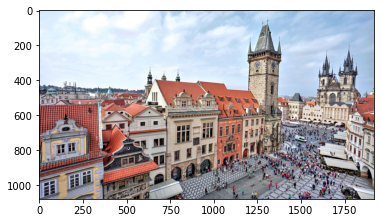

torch.Size([1, 3, 1080, 1920])


In [8]:
content = plot_tensored_image(path = './Input_Data/Content/oldtown_5.jpg')

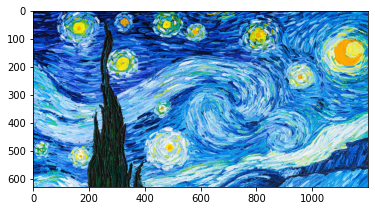

torch.Size([1, 3, 630, 1200])


In [9]:
style = plot_tensored_image(path = './Input_Data/Style/style_8.jpg')

## 4. Models used in Forward Pass

### 4.1. VGG19 For Content Loss and Style Loss

#### 4.1.1. VGG structure and Layer Selection

In [23]:
vgg=models.vgg19(pretrained=True)

In [24]:
style_layers = [1, 6, 11, 20, 29]
content_layers = [22, 31]

#### 4.1.2. Custom layers to reconstruct VGG

In [10]:
class NormalizeLayer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super(NormalizeLayer, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean)/self.std

In [11]:
class Content_Layer(nn.Module):
    def __init__(self):
        super(Content_Layer, self).__init__()
        self.rep=0

    def forward(self, input):
        self.rep = input.clone()
        return input

In [12]:
class Style_Layer(nn.Module):
    def __init__(self):
        super(Style_Layer, self).__init__()
        self.rep=0
        
    @staticmethod
    def gram_matrix(img):
        a, b, c, d = img.size()
        img_reshaped = img.view(a * b, c * d)
        gram = torch.mm(img_reshaped, img_reshaped.t())
        return gram.div_(c * d)
        
    def forward(self, input):
        self.rep = self.gram_matrix(input)
        return input

#### 4.1.3. Reconstructing VGG model with the selected layers

In [13]:
class VGG_Reconstructed(nn.Module):
    def __init__(self, vgg=models.vgg19(pretrained=True), content_index=[22, 31], style_index=[1, 6, 11, 20, 29]):
        super(VGG_Reconstructed, self).__init__()
        
        self.content_access = []
        self.style_access = []
        
        self.model = nn.Sequential()
        self.model.add_module('norm', NormalizeLayer())
        max_layer = max(max(content_index), max(style_index))
        content_counter = 0
        style_counter = 0
        
        for i, layer in enumerate(vgg.features.children()):
            if i <= max_layer:
                if isinstance(layer, nn.Conv2d):
                    self.model.add_module('conv_{}'.format(i), layer)
                elif isinstance(layer, nn.ReLU):
                    self.model.add_module('relu_{}'.format(i), layer)
                elif isinstance(layer, nn.BatchNorm2d):
                    self.model.add_module('bn_{}'.format(i), layer)
                elif isinstance(layer, nn.MaxPool2d):
                    self.model.add_module('pool_{}'.format(i), layer)

                if i in content_index:
                    content = Content_Layer()
                    self.model.add_module('content_{}'.format(content_counter), content)
                    content_counter+=1
                    self.content_access.append(content)
                if i in style_index:
                    style = Style_Layer()
                    self.model.add_module('style_{}'.format(style_counter), style)
                    style_counter+=1
                    self.style_access.append(style)
                    
        self.model.requires_grad_(False)
        del(vgg)
        
    def forward(self, img):
        y = self.model(img)
        content = []
        style = []
        for rep in self.content_access:
            item = rep.rep.clone()
            content.append(item)
            
        for rep in self.style_access:
            item = rep.rep.clone()
            style.append(item)
        
        return content, style

In [16]:
content_style_vgg = VGG_Reconstructed(vgg, content_layers, style_layers)

In [17]:
content_style_vgg

VGG_Reconstructed(
  (model): Sequential(
    (norm): NormalizeLayer()
    (conv_0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_1): ReLU(inplace=True)
    (style_0): Style_Layer()
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_3): ReLU(inplace=True)
    (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_6): ReLU(inplace=True)
    (style_1): Style_Layer()
    (conv_7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_8): ReLU(inplace=True)
    (pool_9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_11): ReLU(inplace=True)
    (style_2): Style_Layer()
    (conv_12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_

### 4.2. HED (Holistically-nested edge detection) For Local Structure Loss

#### 4.2.1. Holistically-nested edge detection Model

In [14]:
class HED(nn.Module):
    def __init__(self):
        super(HED, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=21)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        
        self.score_dsn1 = nn.Conv2d(64, 1, 1)
        self.score_dsn2 = nn.Conv2d(128, 1, 1)
        self.score_dsn3 = nn.Conv2d(256, 1, 1)
        self.score_dsn4 = nn.Conv2d(512, 1, 1)
        self.score_dsn5 = nn.Conv2d(512, 1, 1)
        self.new_score_weighting = nn.Conv2d(5, 1, 1)
        
        self.load_state_dict(torch.load("./pretrained_models/hed_model.pth")['state_dict'])

    def forward(self, x):
        # VGG
        img_H, img_W = x.shape[2], x.shape[3]
        conv1_1 = self.relu(self.conv1_1(x))
        conv1_2 = self.relu(self.conv1_2(conv1_1))
        pool1   = self.maxpool(conv1_2)

        conv2_1 = self.relu(self.conv2_1(pool1))
        conv2_2 = self.relu(self.conv2_2(conv2_1))
        pool2   = self.maxpool(conv2_2)

        conv3_1 = self.relu(self.conv3_1(pool2))
        conv3_2 = self.relu(self.conv3_2(conv3_1))
        conv3_3 = self.relu(self.conv3_3(conv3_2))
        pool3   = self.maxpool(conv3_3)

        conv4_1 = self.relu(self.conv4_1(pool3))
        conv4_2 = self.relu(self.conv4_2(conv4_1))
        conv4_3 = self.relu(self.conv4_3(conv4_2))
        pool4   = self.maxpool(conv4_3)

        conv5_1 = self.relu(self.conv5_1(pool4))
        conv5_2 = self.relu(self.conv5_2(conv5_1))
        conv5_3 = self.relu(self.conv5_3(conv5_2))

        so1 = self.score_dsn1(conv1_2)
        so2 = self.score_dsn2(conv2_2)
        so3 = self.score_dsn3(conv3_3)
        so4 = self.score_dsn4(conv4_3)
        so5 = self.score_dsn5(conv5_3)

        weight_deconv2 =  make_bilinear_weights(4, 1)#.cuda()
        weight_deconv3 =  make_bilinear_weights(8, 1)#.cuda()
        weight_deconv4 =  make_bilinear_weights(16, 1)#.cuda()
        weight_deconv5 =  make_bilinear_weights(32, 1)#.cuda()

        upsample2 = torch.nn.functional.conv_transpose2d(so2, weight_deconv2, stride=2)
        upsample3 = torch.nn.functional.conv_transpose2d(so3, weight_deconv3, stride=4)
        upsample4 = torch.nn.functional.conv_transpose2d(so4, weight_deconv4, stride=8)
        upsample5 = torch.nn.functional.conv_transpose2d(so5, weight_deconv5, stride=16)

        so1 = crop(so1, img_H, img_W)
        so2 = crop(upsample2, img_H, img_W)
        so3 = crop(upsample3, img_H, img_W)
        so4 = crop(upsample4, img_H, img_W)
        so5 = crop(upsample5, img_H, img_W)

        fusecat = torch.cat((so1, so2, so3, so4, so5), dim=1)
        fuse = self.new_score_weighting(fusecat)
        results = [so1, so2, so3, so4, so5, fuse]
        results = [torch.sigmoid(r) for r in results]
        return results

def crop(variable, th, tw):
    h, w = variable.shape[2], variable.shape[3]
    x1 = int(round((w - tw) / 2.))
    y1 = int(round((h - th) / 2.))
    return variable[:, :, y1 : y1 + th, x1 : x1 + tw]

# make a bilinear interpolation kernel
def upsample_filt(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)

# set parameters s.t. deconvolutional layers compute bilinear interpolation
# N.B. this is for deconvolution without groups
def interp_surgery(in_channels, out_channels, h, w):
    weights = np.zeros([in_channels, out_channels, h, w])
    if in_channels != out_channels:
        raise ValueError("Input Output channel!")
    if h != w:
        raise ValueError("filters need to be square!")
    filt = upsample_filt(h)
    weights[range(in_channels), range(out_channels), :, :] = filt
    return np.float32(weights)

def make_bilinear_weights(size, num_channels):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    # print(filt)
    filt = torch.from_numpy(filt)
    w = torch.zeros(num_channels, num_channels, size, size)
    w.requires_grad = False
    for i in range(num_channels):
        for j in range(num_channels):
            if i == j:
                w[i, j] = filt
    return w

def upsample(input, stride, num_channels=1):
    kernel_size = stride * 2
    kernel = make_bilinear_weights(kernel_size, num_channels)#.cuda()
    return torch.nn.functional.conv_transpose2d(input, kernel, stride=stride)

#### 4.2.2. Loading Pretrained Parameters to the Instance of the Model and Test it

In [19]:
hed_model = HED()

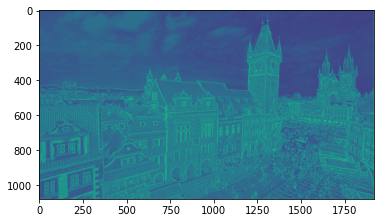

torch.Size([1, 1, 1080, 1920])


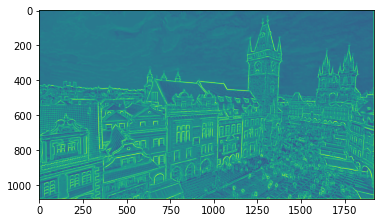

torch.Size([1, 1, 1080, 1920])


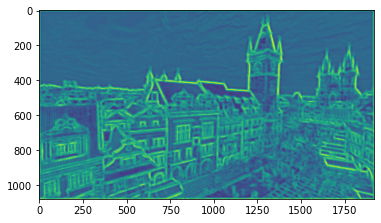

torch.Size([1, 1, 1080, 1920])


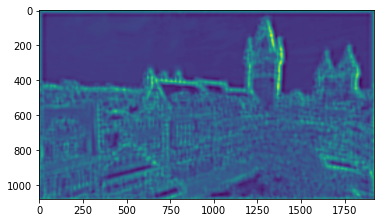

torch.Size([1, 1, 1080, 1920])


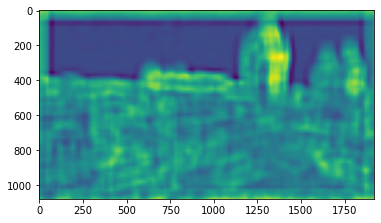

torch.Size([1, 1, 1080, 1920])


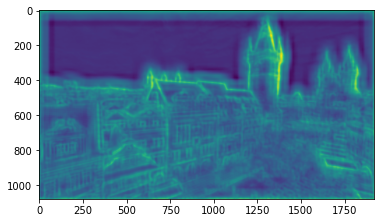

torch.Size([1, 1, 1080, 1920])


In [20]:
for image in hed_model(content):
    hed_image = plot_tensored_image(image)

### 4.3. MiDaS for Depth Estimation as a Global Structure Loss

#### 4.3.1. Building Blocks

In [15]:
class ResizeLayer(nn.Module):
    def __init__(self, target, multiplier = 32):
        
        super(ResizeLayer, self).__init__()
        self.target = target
        self.resize = None
        self.multiplier = multiplier
        
    def forward(self, x):
        
        if self.resize != None:
            return self.resize(x)
        
        input_shape = (x.shape[-2], x.shape[-1])
        
        self.scale = min(self.target[0]/input_shape[0], self.target[1]/input_shape[1])
        
        height = self.multiplier_constrain(self.scale*input_shape[0], max_val=self.target[0])
        width = self.multiplier_constrain(self.scale*input_shape[1], max_val=self.target[1])
        
        self.resize = transforms.Resize((height, width), 
                                   interpolation = transforms.InterpolationMode.BICUBIC)
        
        return self.resize(x)
    
    def multiplier_constrain(self, x, min_val=0, max_val=None):
        y = int(round(x/self.multiplier)*self.multiplier)
        
        if max_val is not None and y > max_val:
            y = int(x - x%self.multiplier)

        return y

In [16]:
class NormalizeLayer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        
        super(NormalizeLayer, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)#.to(device)
        self.std = torch.tensor(std).view(-1, 1, 1)#.to(device)
        
    def forward(self, x):
        return (x - self.mean)/self.std

#### 4.3.2. The Assembled Model

In [17]:
class MidasForNST(nn.Module):
    def __init__(self, target = (256, 256), mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225], multiplier = 32):
        
        super(MidasForNST, self).__init__()
        self.resize = ResizeLayer(target, multiplier = 32)#.to(device)
        self.normalize = NormalizeLayer(mean = mean, std = std)#.to(device)
        model_type = "MiDaS_small"
        self.midas = torch.hub.load("intel-isl/MiDaS", model_type)#.to(device)
        
    def forward(self, x):
        img = self.resize(x)
        img = self.normalize(img)
        output = self.midas(img)
        return output

#### 4.3.3. Model Instanciation and Testing

In [24]:
midas = MidasForNST()

Using cache found in C:\Users\Hussein/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\Hussein/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


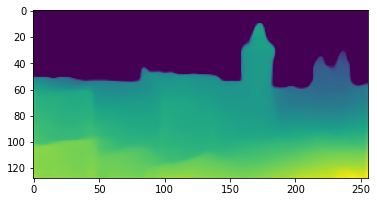

torch.Size([1, 1, 128, 256])


In [25]:
depth_image = plot_tensored_image(midas(content).unsqueeze(0))

## 5. Defining Loss Functions

In [18]:
class Loss_Functions:
    
    @staticmethod
    def content_style_loss(rep_1, rep_2):
        loss = 0
        assert len(rep_1)==len(rep_2)
        for x, y in zip(rep_1, rep_2):
            loss+= F.mse_loss(x, y)
        return loss
    
    @staticmethod
    def edge_depth_loss(rep_1, rep_2):
        return F.mse_loss(rep_1, rep_2)
    
    @staticmethod
    def variation_loss(pastiche):
        a, b, c, d = pastiche.size()
        x_var = torch.pow((pastiche[:,:,1:,:] - pastiche[:,:,:-1,:]), 2).sum()
        y_var = torch.pow((pastiche[:,:,:,1:] - pastiche[:,:,:,:-1]), 2).sum()

        return (x_var + y_var)/(a*b*c*d)

## 6. Image Optimization Class with Multisize Stroke Feature

In [30]:
class Training:
    def __init__(self, content_data, 
                 style_data, 
                 pastiche = 'content', 
                 variation_loss=True, 
                 perserve=True, 
                 multistroke = True, 
                 lr=0.01, 
                 scaleset = [0.25, 0.5, 1, 2]):
        
        #Preparing Models
        self.content_style_model = VGG_Reconstructed(vgg, content_layers, style_layers)
        self.hed = HED()
        self.depth = MidasForNST()
        
        self.content_style_model.eval()
        self.hed.eval()
        self.depth.eval()

        self.content_style_model.requires_grad_(False)
        self.hed.requires_grad_(False)
        self.depth.requires_grad_(False)
        
        #Content & Style Initialization
        self.content = content_data
        self.style = style_data
        self.perserve = perserve
        self.multistroke = multistroke
        self.scaleset = scaleset
        
        self.content_rep, _, self.hed_rep, self.depth_rep = self.forward_calc(content_data)
        self.style_rep = self.style_rep(style_data)
    
        #Pastiche Initialization
        self.pastiche = self.pastiche_initialization(pastiche)
        self.pastiche.requires_grad_(True)
        
        #Optimization and Loss Instanciation
        self.optimizer = torch.optim.Adam([self.pastiche], lr = lr)
        self.loss_calc = Loss_Functions()
        self.loss_tracker = []
        self.var_loss = variation_loss
        
        
    def forward_calc(self, img):
        content_pastiche, style_pastiche = self.content_style_model(img)
        if self.perserve:
            hed_pastiche = self.hed(img)[0]
            depth_pastiche = self.depth(img)
        else:
            hed_pastiche = None
            depth_pastiche = None
        return content_pastiche, style_pastiche, hed_pastiche, depth_pastiche
    
    def style_rep(self, img):
        if self.multistroke:
            h, w = img.shape[-2], img.shape[-1]
            _, style_pastiche_0 = self.content_style_model(img)
            for x in self.scaleset:
                z = transforms.Resize(size=(int(x*h), int(x*w)))(img)
                print(z.shape)
                _, style_pastiche_1 = self.content_style_model(z)
                style_pastiche_0 = list(map(lambda x, y: x+y, style_pastiche_0, style_pastiche_1))
            
            if 1 in self.scaleset:
                _, style_pastiche_1 = self.content_style_model(img)
                style_pastiche_0 = list(map(lambda x, y: x-y, style_pastiche_0, style_pastiche_1))
            
            style_pastiche_0 = list(map(lambda x: x/len(self.scaleset), style_pastiche_0))

        else:
            _, style_pastiche_0 = self.content_style_model(img)
        return style_pastiche_0
    
    def pastiche_initialization(self, pastiche = 'content'):
        if pastiche == 'content':
            self.pastiche = self.content.clone()
        elif pastiche == 'random':
            self.pastiche = torch.rand([1, 3, self.content.shape[-2], self.content.shape[-1]])
        else:
            if pastiche.shape == self.content.shape:
                self.pastiche = pastiche
            else:
                self.pastiche = transforms.Resize((self.content.shape[-2], self.content.shape[-1]))(pastiche)
        return self.pastiche
        
        
    def training_epoch(self, loss_weights, lr = None):
        #Dynamic Learning Rate
        if lr:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = lr
        
        # Zeroing Optimizer
        self.optimizer.zero_grad()
        
        #Forward Pass
        pastiche_content, pastiche_style, pastiche_hed, pastiche_depth = self.forward_calc(self.pastiche)
        
        #Loss Calculation
        loss_data = self.total_loss_calc(pastiche_content, pastiche_style, pastiche_hed, pastiche_depth)
        total_loss = 0
        for loss_value, weight in zip(loss_data[:len(loss_weights)], loss_weights):
            total_loss += loss_value*weight
        
        #Backprobagation
        total_loss.backward()
        #Updating the image
        self.optimizer.step()
        with torch.no_grad():
            self.pastiche.clamp_(0, 1)
        
        return self.pastiche, self.loss_tracker
    
    
    def total_loss_calc(self, content_pastiche, style_pastiche, hed_pastiche, depth_pastiche):
        content_loss = self.loss_calc.content_style_loss(content_pastiche, self.content_rep)
        style_loss = self.loss_calc.content_style_loss(style_pastiche, self.style_rep)
        if self.perserve:
            hed_loss = self.loss_calc.edge_depth_loss(hed_pastiche, self.hed_rep)
            depth_loss = self.loss_calc.edge_depth_loss(depth_pastiche, self.depth_rep)
        else:
            hed_loss = torch.tensor(0)
            depth_loss = torch.tensor(0)

        if self.var_loss:
            variation_loss = self.loss_calc.variation_loss(self.pastiche)
        else:
            variation_loss = torch.tensor(0)
        
        loss_data = (content_loss, style_loss, hed_loss, depth_loss, variation_loss)
        self.loss_tracker.append(list(map(lambda x: x.item(), loss_data)))
        
        return loss_data

## 7. Testing the Optimization Algorithm

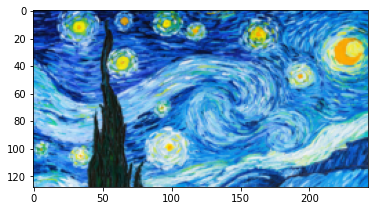

torch.Size([1, 3, 128, 243])


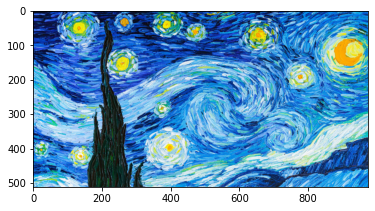

torch.Size([1, 3, 512, 975])


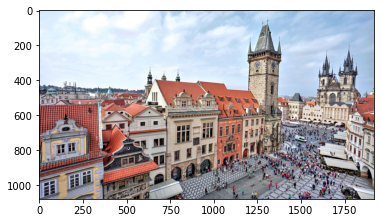

torch.Size([1, 3, 1080, 1920])


In [28]:
style_largestroke = plot_tensored_image(path = './Input_Data/Style/style_8.jpg', transform = transforms.Resize(128))
style_smallstroke = plot_tensored_image(path = './Input_Data/Style/style_8.jpg', transform = transforms.Resize(512))
content = plot_tensored_image(path = './Input_Data/Content/oldtown_5.jpg')

In [29]:
stroke_parameters = {'smallstroke' : {'style_data': style_smallstroke,
                  'multistroke': False
                 }, 
 'largestroke' : {'style_data': style_largestroke,
                  'multistroke': False
                 }, 
 'mixedstroke' : {'style_data': style_smallstroke,
                  'multistroke': True
                 }, 
}

perserve_parameter = {'perserve' : True, 
 'noperserve' : False
}


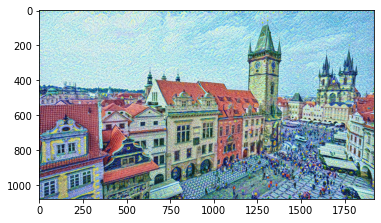

torch.Size([1, 3, 1080, 1920])
epoch 91 where loss Track is equal to [23.08676528930664, 0.4479592442512512, 0, 0, 0.05153936147689819]
epoch 92 where loss Track is equal to [23.206945419311523, 0.44432345032691956, 0, 0, 0.051478445529937744]
epoch 93 where loss Track is equal to [23.059776306152344, 0.4407019317150116, 0, 0, 0.05140560865402222]
epoch 94 where loss Track is equal to [23.241493225097656, 0.4362885355949402, 0, 0, 0.05135096237063408]
epoch 95 where loss Track is equal to [23.07973289489746, 0.43182674050331116, 0, 0, 0.0512797087430954]
epoch 96 where loss Track is equal to [23.2396240234375, 0.42690035700798035, 0, 0, 0.05122600868344307]
epoch 97 where loss Track is equal to [23.125091552734375, 0.4222506582736969, 0, 0, 0.05115976929664612]
epoch 98 where loss Track is equal to [23.22102165222168, 0.4177069664001465, 0, 0, 0.05110607668757439]
epoch 99 where loss Track is equal to [23.175485610961914, 0.41353005170822144, 0, 0, 0.05104633793234825]


In [30]:
def multiple_testing(epochs):
    for stroke_key in stroke_parameters.keys():
        for perserve_key in perserve_parameter.keys():

            training_object = Training(content_data = content, 
                               style_data = stroke_parameters[stroke_key]['style_data'], 
                               pastiche = 'content', 
                               variation_loss=True, 
                               perserve=perserve_parameter[perserve_key], 
                               multistroke=stroke_parameters[stroke_key]['multistroke'],
                               lr = 0.05)

            subfolder_name = f'{stroke_key}_{perserve_key}'
            path = os.path.join('./Output_Data', subfolder_name)
            print(path)

            if not os.path.exists(path):
                os.mkdir(path)

            for i in range(100):
                pastiche, loss_tracker = training_object.training_epoch(loss_weights = [1, 1000000, 1000, 200, 0])
                print(f"epoch {i} where loss Track is equal to {loss_tracker[-1]}")
                torchvision.utils.save_image(transforms.Resize(1000)(pastiche[0, :, :, :].detach()), fp=f'{path}/epoch_{i}.jpg')
                if i%10 == 0:
                    plot_image(pastiche)


## 8. Visualizing & Comparing the Different Pastiches

In [62]:
gc.collect()
%reset in out

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Flushing input history
Flushing output cache (0 entries)


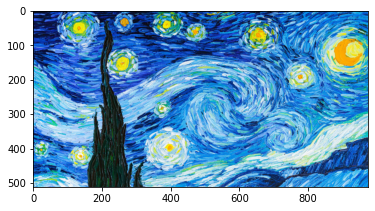

torch.Size([1, 3, 512, 975])


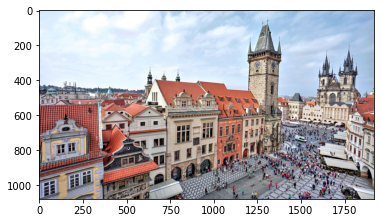

torch.Size([1, 3, 1080, 1920])


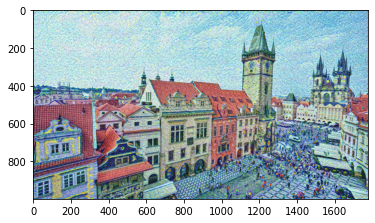

torch.Size([1, 3, 1000, 1777])


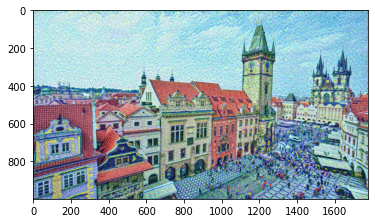

torch.Size([1, 3, 1000, 1777])


In [20]:
style_smallstroke = plot_tensored_image(path = './Input_Data/Style/style_8.jpg', transform = transforms.Resize(512))
content = plot_tensored_image(path = './Input_Data/Content/oldtown_5.jpg')

pastiche_perserved = plot_tensored_image('./Output_Data/mixedstroke_perserve/epoch_99.jpg')
pastiche_noperserved = plot_tensored_image('./Output_Data/mixedstroke_noperserve/epoch_99.jpg')

In [21]:
hed_model = HED()
F.mse_loss(hed_model(transforms.Resize((content.shape[-2], content.shape[-1]))(pastiche_perserved))[0], hed_model(content)[0])

tensor(3.1242e-06, grad_fn=<MseLossBackward0>)

## 9. Fine Tuning Optimization

In [37]:
def retrain(epochs, learning, weights, z):
    pastiche_perserved = plot_tensored_image(f'./Output_Data/mixedstroke_perserve/epoch_{z-1}.jpg')
    training_object = Training(content_data = content, 
                                   style_data = style_smallstroke, 
                                   pastiche = pastiche_perserved, 
                                   variation_loss=True, 
                                   perserve=True, 
                                   multistroke=True,
                                   lr = learning)
    for i in range(epochs):
        pastiche, loss_tracker = training_object.training_epoch(loss_weights = weights)
        print(f"epoch {i} where loss Track is equal to {loss_tracker[-1]}")
        torchvision.utils.save_image(transforms.Resize(1000)(pastiche[0, :, :, :].detach()), fp=f'./Output_Data/mixedstroke_perserve/epoch_{i+z}.jpg')
        if i%10 == 0:
            plot_image(pastiche)
    

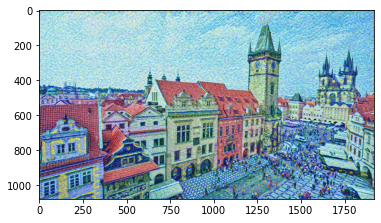

torch.Size([1, 3, 1080, 1920])
epoch 91 where loss Track is equal to [23.422401428222656, 0.3314310908317566, 4.523290044744499e-06, 49.64322280883789, 0.041458871215581894]
epoch 92 where loss Track is equal to [23.428977966308594, 0.32842907309532166, 4.5322080950427335e-06, 48.98625564575195, 0.04142634570598602]
epoch 93 where loss Track is equal to [23.434364318847656, 0.3254851996898651, 4.541144789982354e-06, 48.34730529785156, 0.041394468396902084]
epoch 94 where loss Track is equal to [23.43737030029297, 0.3225966691970825, 4.550095127342502e-06, 47.727115631103516, 0.041363250464200974]
epoch 95 where loss Track is equal to [23.443735122680664, 0.319761723279953, 4.559080480248667e-06, 47.12160873413086, 0.04133301228284836]
epoch 96 where loss Track is equal to [23.44792938232422, 0.31697964668273926, 4.568089480017079e-06, 46.53499984741211, 0.04130333662033081]
epoch 97 where loss Track is equal to [23.451580047607422, 0.3142475187778473, 4.577117124426877e-06, 45.96487808

In [31]:
retrain(100, 0.03, [1, 10000000, 100000000, 200, 0], z=100)

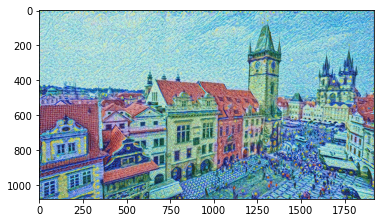

torch.Size([1, 3, 1080, 1920])
epoch 41 where loss Track is equal to [23.600799560546875, 0.5597527623176575, 5.274530849419534e-06, 27801.125, 0.052061788737773895]
epoch 42 where loss Track is equal to [23.573287963867188, 0.5406619906425476, 5.27888414580957e-06, 27337.220703125, 0.051748719066381454]
epoch 43 where loss Track is equal to [23.613195419311523, 0.522680401802063, 5.283995506033534e-06, 27412.3203125, 0.051453862339258194]
epoch 44 where loss Track is equal to [23.627946853637695, 0.5059695839881897, 5.289546152198454e-06, 27519.693359375, 0.05116969347000122]
epoch 45 where loss Track is equal to [23.625423431396484, 0.49042919278144836, 5.295402843330521e-06, 27388.919921875, 0.050897423177957535]
epoch 46 where loss Track is equal to [23.66633415222168, 0.47558140754699707, 5.301671990309842e-06, 27146.642578125, 0.05064046382904053]
epoch 47 where loss Track is equal to [23.658409118652344, 0.4616429805755615, 5.308229901856976e-06, 26744.35546875, 0.05039174109697

In [38]:
retrain(50, 0.05, [100, 10000000, 10000000000, 0, 0], z=200)

## 10. Creating a Video Recorder

In [61]:
import cv2
import numpy as np
import glob

photos = os.listdir('./Output_Data/mixedstroke_perserve')
photos = sorted([os.path.join('./Output_Data/mixedstroke_perserve', photo) for photo in photos])

img_array = []
for photo in photos:
    img = cv2.imread(photo)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## 11. References

#### Papers: 

1. [Neural Style Transfer Review](https://github.com/ycjing/Neural-Style-Transfer-Papers)
2. [Gatys's Paper](https://arxiv.org/abs/1508.06576)
3. [Ghiasi's Paper](https://arxiv.org/pdf/1705.06830.pdf)
4. [Structure poerserving Neural Style Transfer](https://www.researchgate.net/publication/335441628_Structure-Preserving_Neural_Style_Transfer)
5. [Holistically-Nested Edge Detection](https://arxiv.org/abs/1504.06375)
6. [Single-Image Depth Perception in the Wild](https://proceedings.neurips.cc/paper/2016/file/0deb1c54814305ca9ad266f53bc82511-Paper.pdf)


#### Implementations

1. [TensorFlow Lite Tutorial](https://www.tensorflow.org/lite/examples/style_transfer/overview)
2. [TensorFlow Tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer)
3. [PyTorch Tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html?highlight=neural%20style)

4. [Magenta](https://github.com/magenta/magenta/tree/main/magenta/models/arbitrary_image_stylization)
5. [Implementations for Ghiasi Model](https://paperswithcode.com/paper/exploring-the-structure-of-a-real-time)
6. [Real time style based implementation](https://medium.com/@chimezie.iwuanyanwu/real-time-style-transfer-caffa3393833)
7. [Structure-Preserving Neural Style Transfer](https://github.com/xch-liu/structure-nst)
8. [Structure Preserving Implementation](https://github.com/xch-liu/structure-nst)
9. [Total Variation Loss](https://towardsdatascience.com/practical-techniques-for-getting-style-transfer-to-work-19884a0d69eb#:~:text=Total%20variation%20loss%20is%20the,noise%20is%20in%20the%20images.)
10. [Useful Experiments on NST](https://towardsdatascience.com/experiments-on-different-loss-configurations-for-style-transfer-7e3147eda55e)
11. [NST Implementation](https://github.com/ProGamerGov/neural-style-pt)
12. [HED Model on Github](https://github.com/meteorshowers/hed)
13. [Depth Model on Github](https://github.com/xch-liu/structure-nst/blob/master/doc/training.md)